# Comparing results with baseline and chance level

Neste notebook, apresentamos como comparar o desempenho de generalização de um modelo a uma linha de base mínima.

De fato, no portátil anterior, comparamos o erro de teste levando em consideração a distribuição alvo. Uma boa prática é comparar o erro de teste com uma linha de base fictícia e o nível de chance. Na regressão, poderíamos usar `DummyRegressore` prever a meta média sem usar os dados. O nível de chance pode ser determinado permutando os rótulos e verificando a diferença do resultado.

Portanto, conduziremos um experimento para obter a pontuação de um modelo e as duas linhas de base. Começaremos carregando o conjunto de dados de habitação da Califórnia.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

Em todas as avaliações, usaremos uma `ShuffleSplit` validação cruzada.

In [2]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

Começaremos executando a validação cruzada para o regressor da árvore de decisão, que é o nosso modelo de interesse. Além disso, armazenaremos o erro de teste em uma série de pandas.

In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
result_regressor = cross_validate(regressor, data, target,
                                  cv=cv, scoring="neg_mean_absolute_error",
                                  n_jobs=2)

errors_regressor = pd.Series(-result_regressor["test_score"],
                             name="Regressor error")
errors_regressor.describe()

count    30.000000
mean     45.683117
std       1.220644
min      42.813338
25%      44.922931
50%      45.875259
75%      46.631296
max      48.255857
Name: Regressor error, dtype: float64

Em seguida, avaliaremos nossa primeira linha de base. Essa linha de base é chamada de regressor fictício. Este regressor fictício sempre prevê a meta média calculada no treinamento. Portanto, o regressor fictício nunca usará nenhuma informação sobre os dados `data`.

In [5]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
result_dummy = cross_validate(dummy, data, target,
                              cv=cv, scoring="neg_mean_absolute_error",
                              n_jobs=2)
errors_dummy = pd.Series(-result_dummy["test_score"], name="Dummy error")
errors_dummy.describe()

count    30.000000
mean     91.140009
std       0.821140
min      89.757566
25%      90.543652
50%      91.034555
75%      91.979007
max      92.477244
Name: Dummy error, dtype: float64

Finalmente, avaliaremos o desempenho de generalização da segunda linha de base. Esta linha de base fornecerá o desempenho de generalização do nível de chance. Na verdade, treinaremos uma árvore de decisão em alguns dados de treinamento e avaliaremos a mesma árvore em dados onde o vetor alvo foi randomizado.

In [6]:
from sklearn.model_selection import permutation_test_score

regressor = DecisionTreeRegressor()
score, permutation_score, pvalue = permutation_test_score(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error",
    n_jobs=2, n_permutations=30)
errors_permutation = pd.Series(-permutation_score, name="Permuted error")
errors_permutation.describe()

count     30.000000
mean     129.260373
std        0.293633
min      128.761138
25%      129.049368
50%      129.196263
75%      129.509477
max      129.977584
Name: Permuted error, dtype: float64

Finalmente, plotamos os erros de teste para as duas linhas de base e o regressor real.

In [7]:
final_errors = pd.concat([errors_regressor, errors_dummy, errors_permutation],
                         axis=1)
final_errors

,Regressor error,Dummy error,Permuted error
0,46.358811,90.713153,129.062256
1,46.700845,90.539353,129.561194
2,44.563802,91.941912,128.929266
3,43.708230,90.213912,129.088553
4,47.663443,92.015862,129.041882
5,44.921332,90.542490,129.250334
6,44.288727,89.757566,129.977584
7,45.107942,92.477244,128.761138
8,45.247570,90.947952,129.104656
9,44.451177,91.991373,129.545252


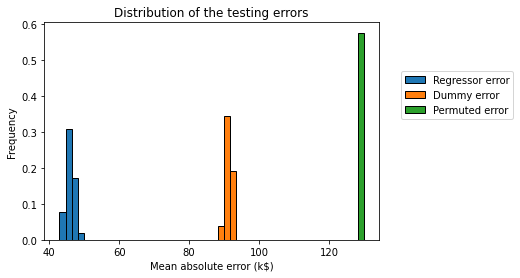

In [7]:
import matplotlib.pyplot as plt

final_errors.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Distribution of the testing errors")

Vemos que, mesmo que o desempenho de generalização de nosso modelo esteja longe de ser bom, ele é melhor do que as duas linhas de base. Além disso, vemos que o regressor dummy é melhor do que um regressor de nível de chance.

Na prática, o uso de um regressor fictício pode ser suficiente como linha de base. Na verdade, para obter uma estimativa confiável, a permutação do alvo deve ser repetida e, portanto, esse método é caro. No entanto, dá o nível de chance real.

# 📝 Exercício M7.01
Este caderno tem como objetivo construir classificadores de linha de base, que usaremos para comparar nosso modelo preditivo. Além disso, vamos verificar as diferenças com as linhas de base que vimos na regressão.

Usaremos o conjunto de dados do censo de adultos, usando apenas os recursos numéricos.

In [9]:
from urllib.request import urlretrieve 
# lembre de sempre pegar o arquivo do tipo RAW no github 
url = 'https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/end-of-v1.0-session/datasets/adult-census-numeric-all.csv'
urlretrieve(url, 'C:/Users/Rogerio Lopes/Desktop/Rogerio/Machine_Learning_With_Scikit_Learn/Module7_evaluanting_model_performance/adult-census-numeric-all.csv')

('C:/Users/Rogerio Lopes/Desktop/Rogerio/Machine_Learning_With_Scikit_Learn/Module7_evaluanting_model_performance/adult-census-numeric-all.csv',
 <http.client.HTTPMessage at 0x1dc8cfc9940>)

In [8]:
import pandas as pd

adult_census = pd.read_csv("adult-census-numeric-all.csv")
data, target = adult_census.drop(columns="class"), adult_census["class"]

Primeiro, defina uma `ShuffleSplit` estratégia de validação cruzada tomando metade da amostra como um teste em cada rodada.

In [9]:
# solution
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)

Em seguida, crie um pipeline de aprendizado de máquina composto por um transformador para padronizar os dados seguido por uma regressão logística.

In [10]:
# solution
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(display='diagram')

classifier = make_pipeline(StandardScaler(), LogisticRegression())
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Obtenha a pontuação do teste usando o modelo, os dados e a estratégia de validação cruzada que você definiu acima.

In [11]:
# solution
from sklearn.model_selection import cross_validate

result_classifier = cross_validate(classifier, data, target, cv=cv, n_jobs=2)

test_score_classifier = pd.Series(
    result_classifier["test_score"], name="Classifier score")
test_score_classifier

0    0.815937
1    0.813849
2    0.815036
3    0.815569
4    0.810982
5    0.814709
6    0.813112
7    0.810327
8    0.812416
9    0.816388
Name: Classifier score, dtype: float64

Usando a `sklearn.model_selection.permutation_test_score` função, verifique o nível de chance do modelo anterior.

In [12]:
# solution
from sklearn.model_selection import permutation_test_score

score, permutation_score, pvalue = permutation_test_score(
    classifier, data, target, cv=cv, n_jobs=2, n_permutations=10)
test_score_permutation = pd.Series(permutation_score, name="Permuted score")
test_score_permutation

0    0.760112
1    0.761238
2    0.760550
3    0.761398
4    0.761001
5    0.761193
6    0.761091
7    0.760923
8    0.761549
9    0.760444
Name: Permuted score, dtype: float64

Finalmente, calcule a pontuação do teste de um classificador fictício que preveria a classe mais frequente do conjunto de treinamento. Você pode olhar para a `sklearn.dummy.DummyClassifierclasse`.

In [16]:
# solution
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
result_dummy = cross_validate(dummy, data, target, cv=cv, n_jobs=2)
test_score_dummy = pd.Series(result_dummy["test_score"], name="Dummy score")

Agora que coletamos os resultados das linhas de base e do modelo, represente graficamente as distribuições das diferentes pontuações dos testes.

Nós concatenamos as diferentes pontuações de teste no mesmo dataframe do pandas.

In [17]:
# solution
final_test_scores = pd.concat(
    [test_score_classifier, test_score_permutation, test_score_dummy],
    axis=1,
)

Em seguida, represente graficamente as distribuições das pontuações dos testes

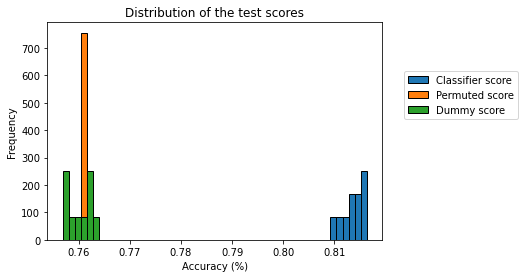

In [18]:
# solution
import matplotlib.pyplot as plt

final_test_scores.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the test scores")

Mude a estratégia do classificador fictício para `stratified`, compute os resultados e plote a distribuição junto com os outros resultados. Explique por que os resultados pioram.

In [19]:
# solution
dummy = DummyClassifier(strategy="stratified")
result_dummy_stratify = cross_validate(dummy, data, target, cv=cv, n_jobs=2)
test_score_dummy_stratify = pd.Series(
    result_dummy_stratify["test_score"], name="Dummy 'stratify' score")

In [20]:
final_test_scores = pd.concat(
    [
        test_score_classifier, test_score_permutation,
        test_score_dummy, test_score_dummy_stratify,
    ],
    axis=1,
)

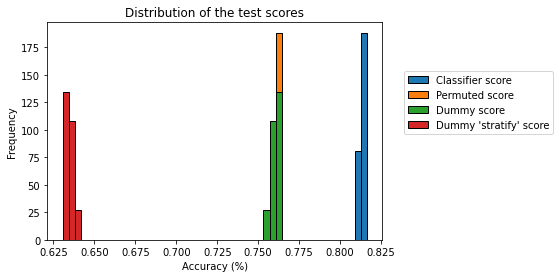

In [21]:
final_test_scores.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the test scores")

Vemos que usando a `strategy="stratified"`, os resultados são muito piores do que com a estratégia `most_frequent`. Como as classes são desequilibradas, prever a mais frequente envolve que estaremos certos para a proporção dessa classe (~ 75% das amostras). No entanto, ao usar a estratégia `stratified`, previsões erradas serão feitas mesmo para a classe mais frequente, portanto, obtemos uma precisão menor.